In [1]:
!git clone https://github.com/ultralytics/yolov5.git
%cd yolov5
!pip install -r requirements.txt


Cloning into 'yolov5'...
remote: Enumerating objects: 17316, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 17316 (delta 17), reused 5 (delta 5), pack-reused 17286 (from 5)
Receiving objects: 100% (17316/17316), 16.20 MiB | 20.30 MiB/s, done.
Resolving deltas: 100% (11880/11880), done.
/kaggle/working/yolov5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 949.8/949.8 kB 23.9 MB/s eta 0:00:0000:01


In [7]:
import os
MODEL_PATH = "/kaggle/input/modelbest/best.pt"  # Update this if different
if not os.path.exists(MODEL_PATH):
    print(f"❌ Model not found at {MODEL_PATH}. Please check training results.")
else:
    print(f"✅ Found trained model: {MODEL_PATH}")

# 🚀 Step 4: Run validation on the test dataset to generate confusion matrix



✅ Found trained model: /kaggle/input/modelbest/best.pt


In [20]:
!python /kaggle/working/yolov5/val.py \
    --weights /kaggle/input/modelbest/best.pt \
    --data /kaggle/working/yolov5/data.yaml \
    --img 640 \
    --task val \
    --save-json \
    --save-txt \
    --conf-thres 0.001




val: data=/kaggle/working/yolov5/data.yaml, weights=['/kaggle/input/modelbest/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=True, save_hybrid=False, save_conf=False, save_json=True, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-407-g324bcfd6 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
Model summary: 157 layers, 7023610 parameters, 0 gradients, 15.8 GFLOPs
val: Scanning /kaggle/input/traffic-detection-project/test/labels... 279 images,
val: WARNING ⚠️ Cache directory /kaggle/input/traffic-detection-project/test is not writeable: [Errno 30] Read-only file system: '/kaggle/input/traffic-detection-project/test/labels.cache.npy'
                 Class     Images  Instances          P          R      mAP50   
                   all        279       3188      0.942      0.904      0.945      0.711
    

In [14]:
!find /kaggle/working -name "data.yaml"


/kaggle/working/yolov5/data.yaml


In [ ]:
# 🚀 Step 5: Display the Confusion Matrix
from IPython.display import Image
import glob

# Find the confusion matrix image in the output directory
conf_matrix_path = glob.glob("/kaggle/working/runs/val/exp/confusion_matrix.png")
if conf_matrix_path:
    display(Image(filename=conf_matrix_path[0]))
else:
    print("❌ Confusion matrix not found. Check if validation ran correctly.")

In [17]:
yaml_content = """
train: /kaggle/input/traffic-detection-project/train/images
val: /kaggle/input/traffic-detection-project/test/images

nc: 5  # Number of classes (update based on your dataset)
names: ['class_0', 'class_1', 'class_2', 'class_3', 'class_4']  # Add meaningful names for each class
"""

with open('data.yaml', 'w') as f:
    f.write(yaml_content)



In [4]:
!python train.py --img 640 --batch 16 --epochs 50 --data data.yaml --weights yolov5s.pt


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2025-03-27 09:20:46.819417: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-27 09:20:47.025133: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-27 09:20:47.085978: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to regi

In [5]:
import shutil

# Define source and destination paths
source_path = '/kaggle/working/yolov5/runs/train/traffic_detection/weights/best.pt'
destination_path = '/kaggle/working/best_model.pt'

# Copy the file to a desired location
shutil.copy(source_path, destination_path)

print(f"Model saved to {destination_path}")


FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/yolov5/runs/train/traffic_detection/weights/best.pt'

In [ ]:
!python val.py --data data.yaml --weights /kaggle/working/yolov5/yolov5s.pt --img 640


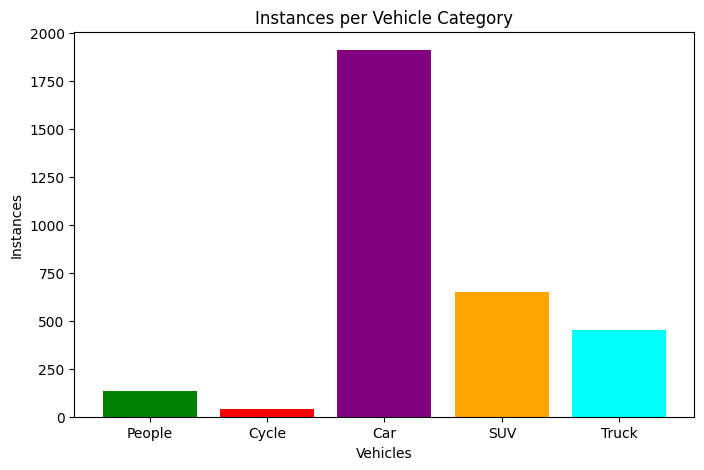

In [2]:
import matplotlib.pyplot as plt

# Data from table
vehicles = [ 'People', 'Cycle', 'Car', 'SUV', 'Truck']
instances = [ 134, 41, 1911, 650, 452]

# Plotting the bar chart
plt.figure(figsize=(8, 5))
plt.bar(vehicles, instances, color=[ 'green', 'red', 'purple', 'orange', 'cyan'])

# Adding labels and title
plt.xlabel('Vehicles')
plt.ylabel('Instances')
plt.title('Instances per Vehicle Category')

# Display the plot
plt.show()


In [ ]:
import os
import random
import torch
import requests
from PIL import Image

from super_gradients.training import Trainer, dataloaders, models
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050

from super_gradients.training.dataloaders.dataloaders import (
    coco_detection_yolo_format_train, 
    coco_detection_yolo_format_val
)

from super_gradients.training.models.detection_models.pp_yolo_e import (
    PPYoloEPostPredictionCallback
)

In [ ]:
class config:
    #trainer params
    CHECKPOINT_DIR = 'checkpoints' #specify the path you want to save checkpoints to
    EXPERIMENT_NAME = 'finding-battleships' #specify the experiment name
    #dataset params
    DATA_DIR = '/kaggle/input/traffic-detection-project' #parent directory to where data lives
    TRAIN_IMAGES_DIR = 'train/images' #child dir of DATA_DIR where train images are
    TRAIN_LABELS_DIR = 'train/labels' #child dir of DATA_DIR where train labels are
    VAL_IMAGES_DIR = 'valid/images' #child dir of DATA_DIR where validation images are
    VAL_LABELS_DIR = 'valid/labels' #child dir of DATA_DIR where validation labels are
    TEST_IMAGES_DIR = 'test/images' #child dir of DATA_DIR where test images are
    TEST_LABELS_DIR = 'test/labels' #child dir of DATA_DIR where test labels are

    CLASSES = ['bicycle', 'bus', 'car', 'motorbike', 'person']

    NUM_CLASSES = len(CLASSES)

    #dataloader params - you can add whatever PyTorch dataloader params you have
    #could be different across train, val, and test
    DATALOADER_PARAMS={
    'batch_size':16,
    'num_workers':2
    }

    # model params
    MODEL_NAME = 'yolo_nas_l' # choose from yolo_nas_s, yolo_nas_m, yolo_nas_l
    PRETRAINED_WEIGHTS = 'coco' #only one option here: coco

In [1]:
import torch
from PIL import Image

# Load YOLOv5 model
model = torch.hub.load('ultralytics/yolov5', 'custom', path='/kaggle/input/modelbest/best.pt')  # Replace 'best.pt' with the path to your trained model

# Define test input images
test_images = [
    '/kaggle/input/traffic-detection-project/test/images/aguanambi-1000_png_jpg.rf.7179a0df58ad6448028bc5bc21dca41e.jpg',  # Replace with the path to your test images
    '/kaggle/input/traffic-detection-project/test/images/aguanambi-1095_png_jpg.rf.4d9f0370f1c09fb2a1d1666b155911e3.jpg',
    '/kaggle/input/traffic-detection-project/test/images/aguanambi-1100_png_jpg.rf.8b7574e1c4f3fd7b654c2a693404fd2d.jpg',
    '/kaggle/input/traffic-detection-project/test/images/aguanambi-1240_png_jpg.rf.7e110b54d205ef0537ddc5dec81a79c2.jpg'
]

# Perform inference on test images
results = model(test_images)

# Print results
results.print()  # Prints detected objects in console

# Save results with bounding boxes marked on images
results.save(save_dir='output/')  # Saves output images in 'output/' directory

# Calculate and print the number of vehicles in each image
for i, df in enumerate(results.pandas().xyxy):
    # Filter for vehicle classes (you may need to adjust these based on your specific model's classes)
    vehicle_classes = ['car', 'truck', 'bus', 'motorcycle', 'bicycle']
    
    # Count vehicles in the current image
    vehicle_count = df[df['name'].isin(vehicle_classes)].shape[0]
    
    print(f"\nImage: {test_images[i]}")
    print(f"Total number of vehicles detected: {vehicle_count}")
    
    # Optional: Detailed breakdown by vehicle type
    vehicle_breakdown = df[df['name'].isin(vehicle_classes)]['name'].value_counts()
    print("Vehicle breakdown:")
    print(vehicle_breakdown)

# Optionally, access detailed results as pandas DataFrame
df_results = results.pandas().xyxy  # Bounding box coordinates, confidence, class, and name for each detection
for i, df in enumerate(df_results):
    print(f"\nDetailed Results for {test_images[i]}:")
    print(df)


/usr/local/lib/python3.10/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


YOLOv5 🚀 2025-3-28 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
Model summary: 157 layers, 7023610 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
image 1/4: 640x640 2 class_0s, 17 class_2s, 1 class_3, 1 class_4
image 2/4: 640x640 1 class_0, 18 class_2s, 5 class_3s
image 3/4: 640x640 1 class_0, 14 class_2s, 3 class_3s
image 4/4: 640x640 12 class_2s, 5 class_3s
Speed: 28.2ms pre-process, 15.4ms inference, 70.6ms NMS per image at shape (4, 3, 640, 640)
Saved 4 images to output


Results for /kaggle/input/traffic-detection-project/test/images/aguanambi-1000_png_jpg.rf.7179a0df58ad6448028bc5bc21dca41e.jpg:
          xmin        ymin        xmax        ymax  confidence  class     name
0   476.774078  145.806244  516.952759  200.567810    0.921648      2  class_2
1   506.786041  202.375092  640.000000  363.409637    0.913485      4  class_4
2   393.195312  109.812485  418.429565  152.934158    0.884666      2  class_2
3   356.059570  108.458374  381.584412  150.146088    0.873069      2  class_2
4   330.891968  501.846680  354.175720  615.166382    0.858714      0  class_0
5   304.865295  521.192139  332.155151  634.214111    0.856769      0  class_0
6   402.059357   90.409271  423.582550  124.244797    0.856690      2  class_2
7   401.603394  151.588837  414.140442  199.006927    0.854808      3  class_3
8   382.558075   66.199959  403.418610   99.963890    0.827636      2  class_2
9   392.431519   53.678886  409.859497   80.918770    0.826205      2  class_2
10 

In [1]:
import torch
from PIL import Image

# Load YOLOv5 model
model = torch.hub.load('ultralytics/yolov5', 'custom', path='/kaggle/input/modelbest/best.pt')  # Replace 'best.pt' with the path to your trained model

# Define test input images
test_images = [
    '/kaggle/input/traffic-detection-project/test/images/aguanambi-1000_png_jpg.rf.7179a0df58ad6448028bc5bc21dca41e.jpg',  # Replace with the path to your test images
    '/kaggle/input/traffic-detection-project/test/images/aguanambi-1095_png_jpg.rf.4d9f0370f1c09fb2a1d1666b155911e3.jpg',
    '/kaggle/input/traffic-detection-project/test/images/aguanambi-1100_png_jpg.rf.8b7574e1c4f3fd7b654c2a693404fd2d.jpg',
    '/kaggle/input/traffic-detection-project/test/images/aguanambi-1240_png_jpg.rf.7e110b54d205ef0537ddc5dec81a79c2.jpg'
]

# Perform inference on test images
results = model(test_images)

# Print results
results.print()  # Prints detected objects in console

# Save results with bounding boxes marked on images
results.save(save_dir='output/')  # Saves output images in 'output/' directory

# Calculate and print the number of vehicles in each image
for i, df in enumerate(results.pandas().xyxy):
    # Filter for vehicle classes (you may need to adjust these based on your specific model's classes)
    vehicle_classes = ['car', 'truck', 'bus', 'motorcycle', 'bicycle']
    
    # Count vehicles in the current image
    vehicle_count = df[df['name'].isin(vehicle_classes)].shape[0]
    
    print(f"\nImage: {test_images[i]}")
    print(f"Total number of vehicles detected: {vehicle_count}")
    
    # Optional: Detailed breakdown by vehicle type
    vehicle_breakdown = df[df['name'].isin(vehicle_classes)]['name'].value_counts()
    print("Vehicle breakdown:")
    print(vehicle_breakdown)

# Optionally, access detailed results as pandas DataFrame
df_results = results.pandas().xyxy  # Bounding box coordinates, confidence, class, and name for each detection
for i, df in enumerate(df_results):
    print(f"\nDetailed Results for {test_images[i]}:")
    print(df)

/usr/local/lib/python3.10/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


YOLOv5 🚀 2025-3-28 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
Model summary: 157 layers, 7023610 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
image 1/4: 640x640 2 class_0s, 17 class_2s, 1 class_3, 1 class_4
image 2/4: 640x640 1 class_0, 18 class_2s, 5 class_3s
image 3/4: 640x640 1 class_0, 14 class_2s, 3 class_3s
image 4/4: 640x640 12 class_2s, 5 class_3s
Speed: 47.4ms pre-process, 29.6ms inference, 144.0ms NMS per image at shape (4, 3, 640, 640)
Saved 4 images to output



Image: /kaggle/input/traffic-detection-project/test/images/aguanambi-1000_png_jpg.rf.7179a0df58ad6448028bc5bc21dca41e.jpg
Total number of vehicles detected: 0
Vehicle breakdown:
Series([], Name: count, dtype: int64)

Image: /kaggle/input/traffic-detection-project/test/images/aguanambi-1095_png_jpg.rf.4d9f0370f1c09fb2a1d1666b155911e3.jpg
Total number of vehicles detected: 0
Vehicle breakdown:
Series([], Name: count, dtype: int64)

Image: /kaggle/input/traffic-detection-project/test/images/aguanambi-1100_png_jpg.rf.8b7574e1c4f3fd7b654c2a693404fd2d.jpg
Total number of vehicles detected: 0
Vehicle breakdown:
Series([], Name: count, dtype: int64)

Image: /kaggle/input/traffic-detection-project/test/images/aguanambi-1240_png_jpg.rf.7e110b54d205ef0537ddc5dec81a79c2.jpg
Total number of vehicles detected: 0
Vehicle breakdown:
Series([], Name: count, dtype: int64)

Detailed Results for /kaggle/input/traffic-detection-project/test/images/aguanambi-1000_png_jpg.rf.7179a0df58ad6448028bc5bc21dca41e